# Calculate the coordination number of each residue, draw residue versus coordination number for the protein.

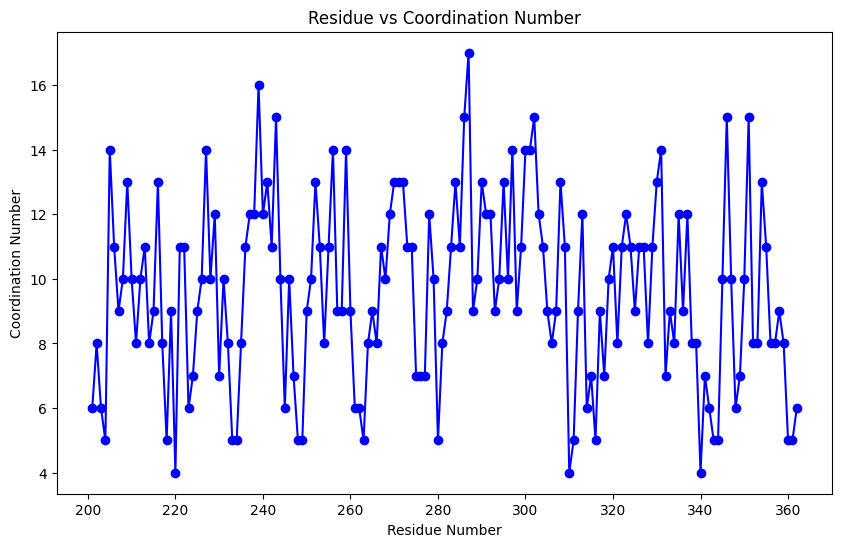

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from Bio.PDB.DSSP import DSSP
from Bio.PDB import PDBParser
from Bio.PDB.MMCIFParser import MMCIFParser

def load_structure(pdb_filename):
    if pdb_filename.endswith('.cif'):
        parser = MMCIFParser(QUIET=True)
    else:
        parser = PDBParser(QUIET=True)
    structure = parser.get_structure('protein', pdb_filename)
    return structure

def calculate_residue_coordination_numbers(structure, chain_id, distance_cutoff=8.0):
    model = structure[0]
    chain = model[chain_id]
    coords = []
    res_ids = []
    for i, residue in enumerate(chain):
        # ignore hetero/water
        if 'CA' in residue:
            atom_coords = [atom.get_coord() for atom in residue if atom.element != "H"]
            coords.append(np.array(atom_coords))
            res_ids.append(residue.get_id())
    # Flatten coords for centroid calculation
    centroids = [np.mean(res, axis=0) for res in coords]
    coordination_numbers = []
    for i, centroid_i in enumerate(centroids):
        count = 0
        for j, centroid_j in enumerate(centroids):
            if i != j:
                dist = np.linalg.norm(centroid_i - centroid_j)
                if dist < distance_cutoff:
                    count += 1
        coordination_numbers.append(count)
    return coordination_numbers, res_ids

def residue_numbers_from_ids(res_ids):
    return [res_id[1] for res_id in res_ids]

pdb_file = "files/1ZUO.cif"
chain_id = "A"              

structure = load_structure(pdb_file)
coord_numbers, res_ids = calculate_residue_coordination_numbers(structure, chain_id)
residue_numbers = residue_numbers_from_ids(res_ids)

plt.figure(figsize=(10,6))
plt.plot(residue_numbers, coord_numbers, marker='o', linestyle='-', color='b')
plt.xlabel("Residue Number")
plt.ylabel("Coordination Number")
plt.title("Residue vs Coordination Number")
plt.show()




# Draw the contact map of the protein, indicate which secondary element correspond where in the map. Which secondary structures contact, show in the map.

/Users/alirezanoroozi/Library/Python/3.9/lib/python/site-packages/Bio/PDB/DSSP.py:199: UserWarning: 
Configuration error:

The attempt to retrieve compound information for "ALA" failed.

This information is searched for in a CCD file called components.cif or
components.cif.gz which should be located in one of the following directories:

"/usr/local/share/libcifpp"
"/usr/local/share/libcifpp"

(Note that you can add a directory to the search paths by setting the 
LIBCIFPP_DATA_DIR environmental variable)

On Linux an optional cron script might have been installed that automatically updates
components.cif and mmCIF dictionary files. This script only works when the file
libcifpp.conf contains an uncommented line with the text:

update=true

If you do not have a working cron script, you can manually update the files
in /var/cache/libcifpp using the following commands:

curl -o /var/cache/libcifpp/components.cif https://files.wwpdb.org/pub/pdb/data/monomers/components.cif
curl -o /var/cache

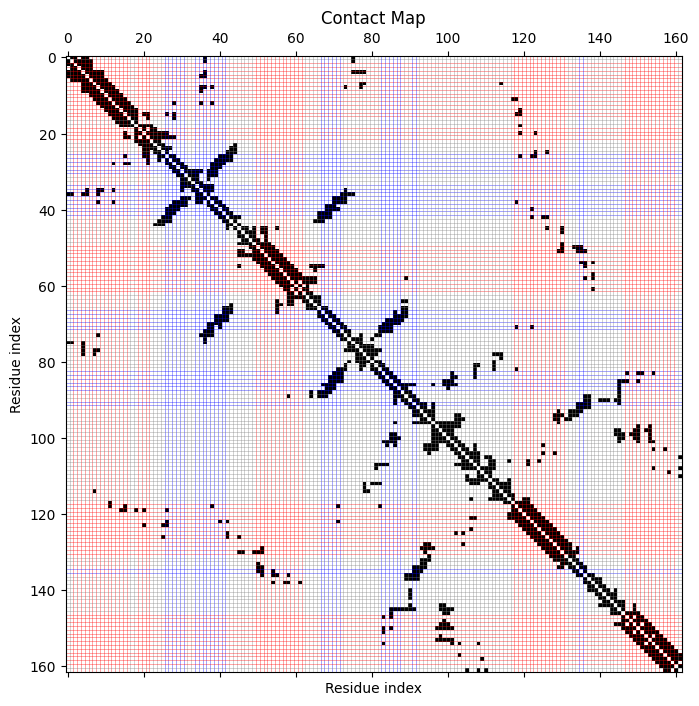

In [3]:
model = structure[0]
dssp = DSSP(model, pdb_file)
ss_map = {'H': 'AlphaHelix', 'B': 'BetaBridge', 'E': 'Strand', 'G': '310Helix', 'I': 'PiHelix', 'T': 'Turn', 'S': 'Bend', '-': 'Coil'}

def get_secondary_structure_list(dssp, res_ids):
    sec_structs = []
    for res_id in res_ids:
        dssp_key = (chain_id, res_id)
        if dssp_key in dssp:
            code = dssp[dssp_key][2]
        else:
            code = "-"
        sec_structs.append(ss_map.get(code, 'Coil'))
    return sec_structs

ss_list = get_secondary_structure_list(dssp, res_ids)
size = len(res_ids)
contact_map = np.zeros((size, size))
centroids = [np.mean([atom.get_coord() for atom in model[chain_id][res_id] if atom.element != "H"], axis=0) for res_id in res_ids]

for i in range(size):
    for j in range(size):
        if i < j:
            dist = np.linalg.norm(centroids[i] - centroids[j])
            if dist < 8.0:
                contact_map[i, j] = 1
                contact_map[j, i] = 1

fig, ax = plt.subplots(figsize=(8,8))
cax = ax.matshow(contact_map, cmap='Greys')
ax.set_xlabel("Residue index")
ax.set_ylabel("Residue index")
ax.set_title("Contact Map")
# Highlight secondary structures on axes
for i, ss in enumerate(ss_list):
    color = {'AlphaHelix':'red','Strand':'blue','Coil':'grey'}.get(ss, 'grey')
    ax.axhline(i-0.5, color=color, linewidth=0.5, alpha=0.5)
    ax.axvline(i-0.5, color=color, linewidth=0.5, alpha=0.5)
plt.show()

# Find the accesible surface areas of the residues

In [4]:
! pip3 install freesasa

Defaulting to user installation because normal site-packages is not writeable


In [5]:
from Bio.PDB import MMCIFParser, PDBIO, Select

# Define your mmCIF filename and output PDB filename
mmcif_filename = pdb_file  # assumed to be defined previously
pdb_filename_tmp = 'files/tmp_chainA.pdb'

# Parse mmCIF, extract only chain A, write to pdb
parser = MMCIFParser(QUIET=True)
structure_cif = parser.get_structure("struct", mmcif_filename)

class ChainSelect(Select):
    def accept_chain(self, chain):
        return chain.id == "A"

io = PDBIO()
io.set_structure(structure_cif)
io.save(pdb_filename_tmp, select=ChainSelect())

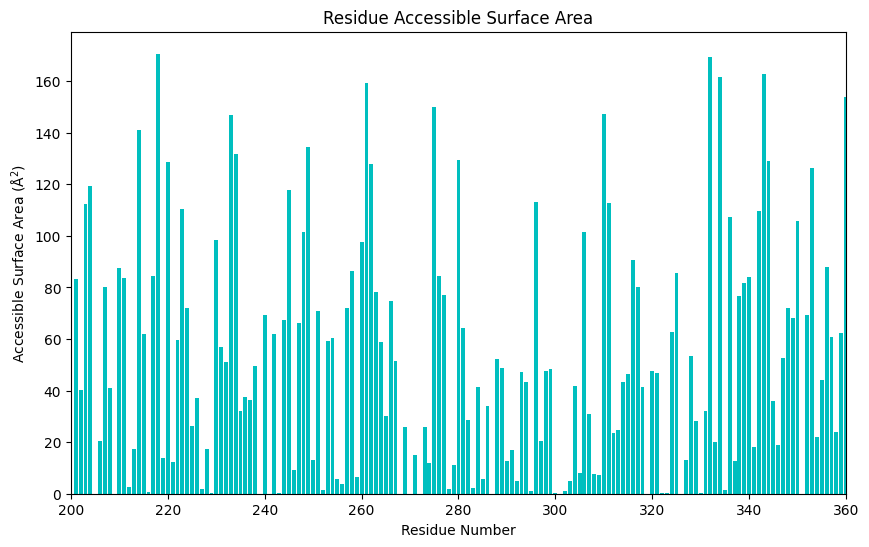

In [6]:
import freesasa

pdb_filename_tmp = 'files/tmp_chainA.pdb'
new_structure = load_structure(pdb_filename_tmp)
chain_id = "A"
new_chain = new_structure[0][chain_id]
new_res_ids = [residue.get_id() for residue in new_chain.get_residues()]
new_residue_numbers = [residue.get_id()[1] for residue in new_chain.get_residues()]

new_structure_freesasa = freesasa.Structure(pdb_filename_tmp, options={'hetatm':False})
new_result = freesasa.calc(new_structure_freesasa)

asa_values = []
for res_id in new_res_ids:
    try:
        resnum = str(res_id[1])
        asa = new_result.residueAreas()[chain_id][resnum].total
    except KeyError:
        asa = 0.0
    asa_values.append(asa)

plt.figure(figsize=(10,6))
plt.bar(new_residue_numbers, asa_values, color='c')
plt.xlim(200, 360)
plt.xlabel("Residue Number")
plt.ylabel("Accessible Surface Area (Å$^2$)")
plt.title("Residue Accessible Surface Area")
plt.show()

# Hydrophobicity (Kyte-Doolittle)

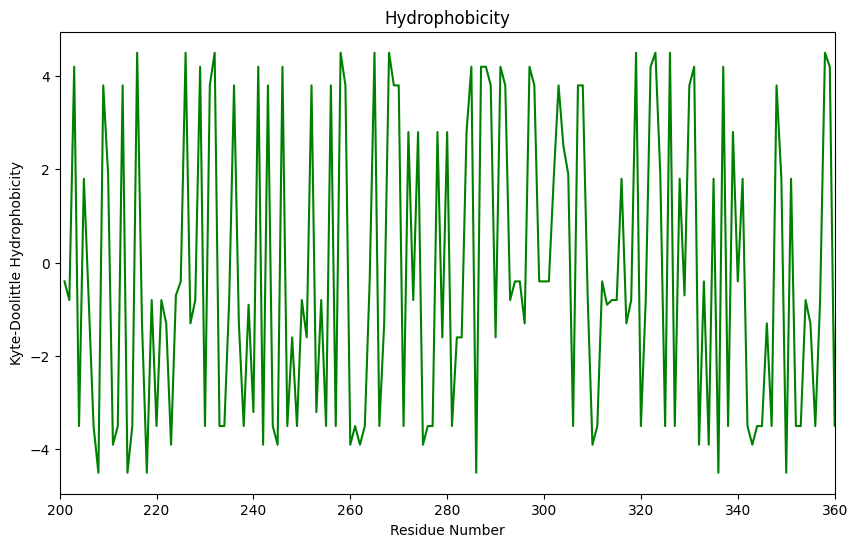

In [8]:
# Hardcoded Kyte-Doolittle hydrophobicity scale
kd_hydrophobicity = {'I': 4.5, 'V': 4.2, 'L': 3.8, 'F': 2.8, 'C': 2.5, 'M': 1.9, 'A': 1.8, 'G': -0.4, 
                     'T': -0.7, 'S': -0.8, 'W': -0.9, 'Y': -1.3, 'P': -1.6, 'H': -3.2, 'E': -3.5, 
                     'Q': -3.5, 'D': -3.5, 'N': -3.5, 'K': -3.9, 'R': -4.5}

def to_one_letter(resname):
    three_to_one = {'ALA':'A','CYS':'C','ASP':'D','GLU':'E','PHE':'F','GLY':'G','HIS':'H','ILE':'I',
                    'LYS':'K','LEU':'L','MET':'M','ASN':'N','PRO':'P','GLN':'Q','ARG':'R','SER':'S',
                    'THR':'T','VAL':'V','TRP':'W','TYR':'Y'}
    return three_to_one.get(resname.upper(),"X")

hydro_values = []
for res_id in new_res_ids:
    resname = to_one_letter(new_chain[res_id].get_resname())
    hydro = kd_hydrophobicity.get(resname, 0.0)
    hydro_values.append(hydro)

plt.figure(figsize=(10,6))
plt.plot(new_residue_numbers, hydro_values, color='g')
plt.xlim(200, 360)
plt.xlabel("Residue Number")
plt.ylabel("Kyte-Doolittle Hydrophobicity")
plt.title("Hydrophobicity")
plt.show()

162
277


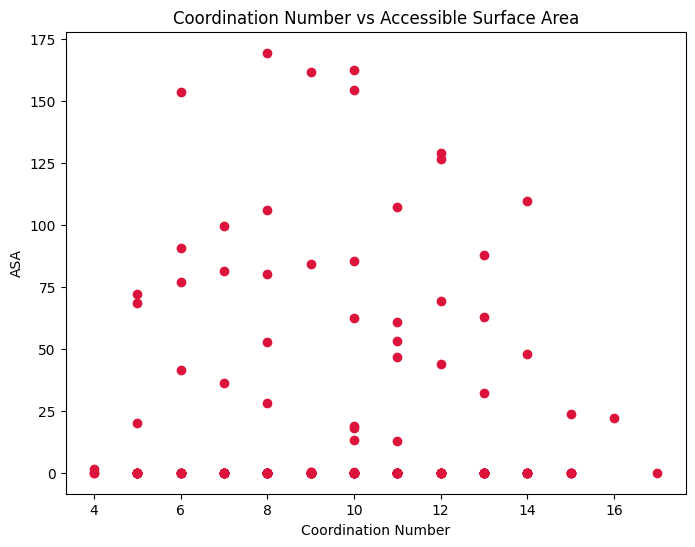

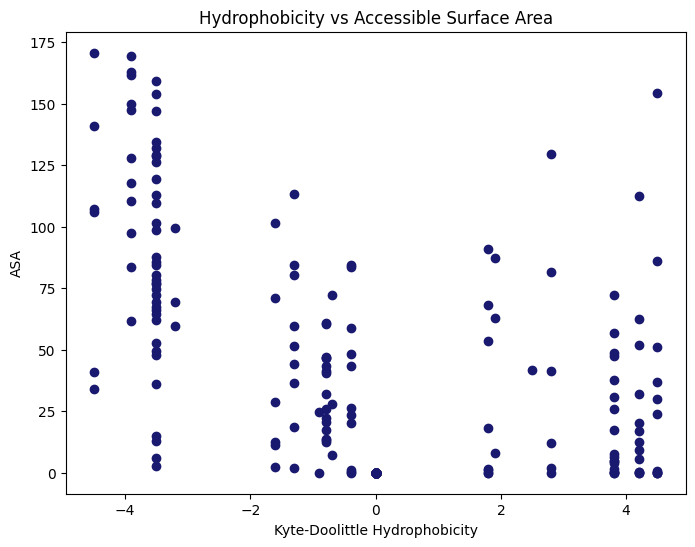

Correlation (Coordination # vs ASA): r = -0.021, p = 0.794
Correlation (Hydrophobicity vs ASA): r = -0.465, p = 2.95e-16


In [12]:
# e. Correlation graphs: i) coordination number vs ASA, ii) hydrophobicity vs ASA
coord_numbers, res_ids = calculate_residue_coordination_numbers(new_structure, chain_id)
print(len(coord_numbers))
print(len(asa_values))

plt.figure(figsize=(8,6))
plt.scatter(coord_numbers, asa_values[-len(coord_numbers):], c='crimson')
plt.xlabel("Coordination Number")
plt.ylabel("ASA")
plt.title("Coordination Number vs Accessible Surface Area")
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(hydro_values, asa_values, c='midnightblue')
plt.xlabel("Kyte-Doolittle Hydrophobicity")
plt.ylabel("ASA")
plt.title("Hydrophobicity vs Accessible Surface Area")
plt.show()

from scipy.stats import pearsonr
corr1, pval1 = pearsonr(coord_numbers, asa_values[-len(coord_numbers):])
corr2, pval2 = pearsonr(hydro_values, asa_values)
print(f"Correlation (Coordination # vs ASA): r = {corr1:.3f}, p = {pval1:.3g}")
print(f"Correlation (Hydrophobicity vs ASA): r = {corr2:.3f}, p = {pval2:.3g}")


As the charge abs increases the ASA also increase

# Find the SCOP domain of this protein

In [13]:
from IPython.display import Image, display

# Show an image, for example of 1ZUO from RCSB (static link)
img_url = "images/image.png"
display(Image(url=img_url))


# the scope Id is `8023910`